In [22]:
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import trange, tqdm
import requests
import copy
import re
import time
import geopandas as gpd
import descartes
from shapely.geometry import Point

In [135]:
#Indlæser geodata:
sti = 'C:/Users/Gustav/Desktop/Social Data Science/Projekt/geodata/dagi_10m_nohist_l1.afstemningsomraade/'
gdf = gpd.read_file(sti+'afstemningsomraade.shp')

#Indlæser baggrundsdata:
background = pd.read_csv('background_vars2019.csv')

In [130]:
background.head()
# background['lat'] = background['lat'].astype(str)+'N'
# background['lon'] = background['lon'].astype(str)+'E'

In [134]:
#Forsøger at konvertere lon/lat-koordinater til UTM-format:
from pyproj import Proj

# myProj = Proj('+proj=utm +zone=32N, +north +ellps=WGS84 +units=m +no_defs')
myProj = Proj('+proj=utm +zone=32N, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
lon1, lat1 = myProj(background['lon'].values, background['lat'].values)

#Creating a points list from the 'lon' og 'lat' variables, that GeoPandas can read as a location:
points = [Point(lon1[i], lat1[i]) for i in range(len(lon1))]

#Converting background data to GeoPandas dataframe:
gdf_background = gpd.GeoDataFrame(background, geometry=points)
gdf_background

TypeError: input must be an array, list, tuple or scalar

Finder nærmeste intitutionsnummer i baggrundsdata, og tilføjer som kolonne i geodatasættet gdf:

In [91]:
from shapely.ops import nearest_points

# unary union of the gpd2 geomtries 
pts3 = gdf_background.geometry.unary_union
def near(point, pts=pts3):
     # find the nearest point and return the corresponding Place value
     nearest = gdf_background.geometry == nearest_points(point, pts)[1]
     return gdf_background[nearest]['institutionsnummer'].values[0]
    
gdf['institutionsnummer'] = gdf.apply(lambda row: near(row.geometry), axis=1)
gdf

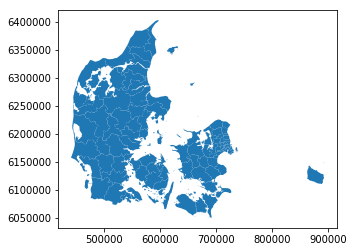

In [16]:
#Aggreger til kommuneniveau:
gdf.dissolve(by='kommunekod').plot()

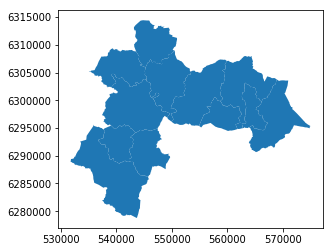

In [17]:
#Plot enkelt kommune:
plt = gdf[(gdf['kommunekod'] == '0840')].plot()

In [ ]:
#Eksporter data:
gdf[['objectid', 'id_lokalid','afstemni00', 'kommunekod']].to_csv('mapping_geodata.csv', encoding='utf-8-sig')